In [8]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
import getpass
import importlib
import tqdm

import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel
import glob
import matplotlib.patches as patches

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'


## ESTIMATE RELIABILITY

In [16]:
glm = 5
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']
sn_list = [101,102,103,104,106,107,108]
hem = ['L','R']
atlas,_ = am.get_atlas('fs32k')
ana = {'sn':[], 
       'hem':[],
       'region':[],
       'cond':[],
       'r':[],
       'r_corr':[]}
for sn in sn_list:
    regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'reginfo.tsv'))
    partitions = regressor_info['run'].values.flatten()
    conds = regressor_info['name'].values.flatten()
    
    for j, h in enumerate(hem):
        # ========================================== 
        # DATA EXTRACTION 
        # ==========================================
        #  Define atlas map

        white = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.white.32k.surf.gii') # Individual white surface
        pial = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.pial.32k.surf.gii') # Invividual pial surface
        mask = os.path.join(baseDir, f'glm{glm}', f's{sn}', 'mask.nii') # Mask in functional space for that subject

        # File names for data extraction
        nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', "beta_*.nii")))
        nii_names = nii_names[0:480] # remove the run constant regressors
        resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn}', 'ResMS.nii')]

        beta = []
        resMS = []
        beta_white = []
        for i, r in enumerate(region_labels):
            atlas_tmp = atlas.get_hemisphere(j)
            subatlas = atlas_tmp.get_subatlas_image(os.path.join(atlasDir,f'ROI.32k.{h}.label.gii'), value=r)
            amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
            # Compute the voxels in native space
            amap.build()

            # save the ROI mask in native space for checking purposes
            amap.save_as_image(os.path.join(baseDir, regDir, f's{sn}', f'amap_ROI_s{sn}_glm{glm}_{h}_{region_names[i]}.nii'))
            
            # This extract all the relevant voxels in native space (use for RSA)
            beta = amap.extract_data_native(nii_names)
            idx_nan = np.isnan(beta).any(axis=0)
            beta = beta[:, ~idx_nan]
            resMS = amap.extract_data_native(resMS_name)
            resMS = resMS[:, ~idx_nan]
            beta_white = beta/np.sqrt(resMS)
            
            # ========================================== 
            # RELIABILITY ESTIMATION
            # ==========================================
            # left hand:
            idx_left = ['lhand' in tmp for tmp in conds]
            data = beta_white[idx_left,:]
            cond_vec = conds[idx_left]
            part_vec = partitions[idx_left]
            r_corr = np.mean(rel.within_subj_loo(data, cond_vec, part_vec,
                            separate = 'none',
                            subtract_mean=True))
            r = rel.within_subj(data, cond_vec, part_vec,
                            separate = 'none',
                            subtract_mean=True)[0]
            ana['r'].append(r)
            ana['r_corr'].append(r_corr)
            ana['sn'].append(sn)
            ana['hem'].append(h)
            ana['region'].append(region_names[i])
            ana['cond'].append('left')

            # right hand:
            idx_right = ['rhand' in tmp for tmp in conds]
            data = beta_white[idx_right,:]
            cond_vec = conds[idx_right]
            part_vec = partitions[idx_right]
            r_corr = np.mean(rel.within_subj_loo(data, cond_vec, part_vec,
                            separate = 'none',
                            subtract_mean=True))
            r = rel.within_subj(data, cond_vec, part_vec,
                            separate = 'none',
                            subtract_mean=True)[0]
            ana['r'].append(r)
            ana['r_corr'].append(r_corr)
            ana['sn'].append(sn)
            ana['hem'].append(h)
            ana['region'].append(region_names[i])
            ana['cond'].append('right')
            
            # bimanual:
            idx_bimanual = ['bi' in tmp for tmp in conds]
            data = beta_white[idx_bimanual,:]
            cond_vec = conds[idx_bimanual]
            part_vec = partitions[idx_bimanual]
            r_corr = np.mean(rel.within_subj_loo(data, cond_vec, part_vec,
                            separate = 'none',
                            subtract_mean=True))
            r = rel.within_subj_loo(data, cond_vec, part_vec,
                            separate = 'none',
                            subtract_mean=True)[0]
            ana['r'].append(r)
            ana['r_corr'].append(r_corr)
            ana['sn'].append(sn)
            ana['hem'].append(h)
            ana['region'].append(region_names[i])
            ana['cond'].append('bimanual')

ana = pd.DataFrame(ana)



/Users/aghavamp/Desktop/Projects/bimanual_wrist/.conda/lib/python3.11/site-packages/nitools/volume.py:122: RuntimeWarning: divide by zero encountered in matmul
  ijk = mat[0:3,0:3] @ coords + mat[0:3,3:]
/Users/aghavamp/Desktop/Projects/bimanual_wrist/.conda/lib/python3.11/site-packages/nitools/volume.py:122: RuntimeWarning: overflow encountered in matmul
  ijk = mat[0:3,0:3] @ coords + mat[0:3,3:]
/Users/aghavamp/Desktop/Projects/bimanual_wrist/.conda/lib/python3.11/site-packages/nitools/volume.py:122: RuntimeWarning: invalid value encountered in matmul
  ijk = mat[0:3,0:3] @ coords + mat[0:3,3:]
/Users/aghavamp/Desktop/Projects/Functional_Fusion/Functional_Fusion/util.py:38: RuntimeWarning: divide by zero encountered in matmul
  B = pinv(X[indx,:]) @ Y[indx,:]
/Users/aghavamp/Desktop/Projects/Functional_Fusion/Functional_Fusion/util.py:38: RuntimeWarning: overflow encountered in matmul
  B = pinv(X[indx,:]) @ Y[indx,:]
/Users/aghavamp/Desktop/Projects/Functional_Fusion/Functional_Fus

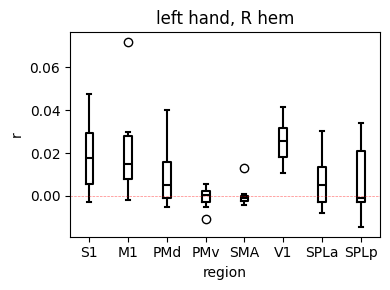

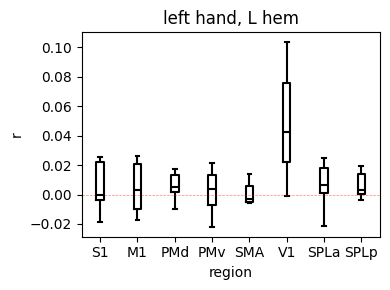

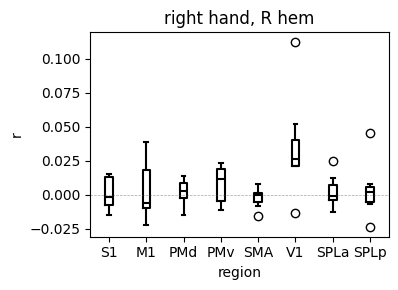

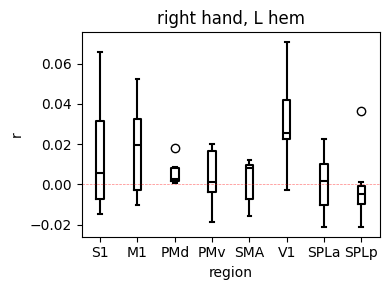

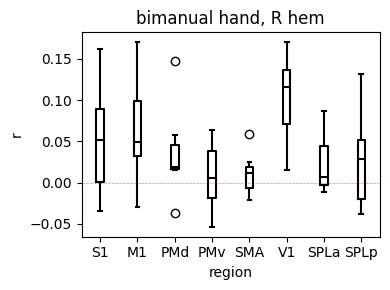

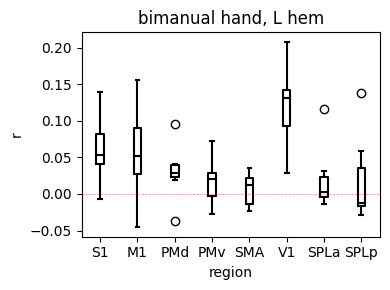

In [17]:
# boxplot reliability:
cond = ['left','right','bimanual']
hem = ['R','L']

for c in cond:
    for h in hem:
        tmp = ana[(ana['cond'] == c) & (ana['hem'] == h)]
        fig, ax = plt.subplots(figsize=(4,3))
        sns.boxplot(data=tmp, x='region', y='r', ax=ax, fill=False, color='black', width=0.2)
        ax.axhline(0, color='red', linestyle='--', alpha=0.5, linewidth=0.5)
        plt.title(f'{c} hand, {h} hem')
        # plt.xticks(rotation=45)
        plt.tight_layout()
        # plt.savefig(os.path.join(baseDir, f'glm{glm}', f'boxplot_reliability_{c}_{h}.png'))
        # plt.close()
        plt.show()